In [2]:
import os
import shutil
import uuid
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [3]:
# ⚠️ Manually update this path before running each dataset
DATASET_FOLDER = "./unfiltered1"  # Change this for each dataset

# Define filtered dataset folder (Persistent across runs)
FILTERED_DATASET_FOLDER = "Filtered_Dataset"

# Emotion categories detected by DeepFace (Matches dataset structure)
EMOTION_CATEGORIES = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]


In [4]:
# Initialize confusion matrix tracking
actual_labels = []
predicted_labels = []

# Step 1: Create the "Filtered_Dataset" folder with emotion subfolders
def initialize_filtered_dataset():
    if not os.path.exists(FILTERED_DATASET_FOLDER):
        os.makedirs(FILTERED_DATASET_FOLDER)

    for emotion in EMOTION_CATEGORIES:
        emotion_folder = os.path.join(FILTERED_DATASET_FOLDER, emotion)
        if not os.path.exists(emotion_folder):
            os.makedirs(emotion_folder)

In [5]:
# Step 2: Process each category separately
def process_category(emotion_category):
    global actual_labels, predicted_labels

    # Define source folder for the category
    source_folder = os.path.join(DATASET_FOLDER, emotion_category)

    # Check if the source folder exists
    if not os.path.exists(source_folder):
        print(f"Skipping {emotion_category}: No such folder in dataset.")
        return

    # Get all images in the category folder
    image_paths = [
        os.path.join(source_folder, file) for file in os.listdir(source_folder)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    print(f"Processing {len(image_paths)} images in category: {emotion_category}")

    for img_path in tqdm(image_paths, desc=f"Processing {emotion_category}"):
        try:
            # Analyze emotion with enforce_detection=False to prevent errors
            result = DeepFace.analyze(img_path=img_path, actions=['emotion'], enforce_detection=False)

            # Check if a face was detected
            if not result or len(result) == 0:
                print(f"Skipping {img_path}: No face detected.")
                continue  # Skip this image

            # Extract the predicted dominant emotion
            predicted_emotion = result[0]['dominant_emotion'].lower()

            # Track results for confusion matrix
            actual_labels.append(emotion_category)
            predicted_labels.append(predicted_emotion)

            # If the prediction matches the current category, copy it to the filtered dataset
            if predicted_emotion == emotion_category:
                target_folder = os.path.join(FILTERED_DATASET_FOLDER, emotion_category)

                # Prevent duplicate filenames by appending a unique identifier
                unique_name = str(uuid.uuid4())[:8] + "_" + os.path.basename(img_path)
                target_path = os.path.join(target_folder, unique_name)

                # Copy image to the correct category
                shutil.copy(img_path, target_path)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue  # Skip the current image and proceed

In [6]:
# Step 3: Generate and display a confusion matrix
def generate_confusion_matrix():
    if len(actual_labels) == 0 or len(predicted_labels) == 0:
        print("No images were processed. Skipping confusion matrix.")
        return

    # Compute confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels, labels=EMOTION_CATEGORIES)

    # Convert to DataFrame for better readability
    cm_df = pd.DataFrame(cm, index=EMOTION_CATEGORIES, columns=EMOTION_CATEGORIES)

    # Display the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted Emotion")
    plt.ylabel("Actual Emotion")
    plt.title("Emotion Classification Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the plot
    plt.show()

Processing 5500 images in category: angry


Processing angry: 100%|██████████| 5500/5500 [17:00<00:00,  5.39it/s]  


Processing 4303 images in category: disgust


Processing disgust: 100%|██████████| 4303/4303 [13:22<00:00,  5.36it/s] 


Processing 5500 images in category: fear


Processing fear: 100%|██████████| 5500/5500 [17:43<00:00,  5.17it/s] 


Processing 5500 images in category: happy


Processing happy: 100%|██████████| 5500/5500 [24:13<00:00,  3.79it/s]  


Processing 500 images in category: sad


Processing sad: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]


Processing 5500 images in category: surprise


Processing surprise: 100%|██████████| 5500/5500 [22:40<00:00,  4.04it/s]  


Processing 9750 images in category: neutral


Processing neutral: 100%|██████████| 9750/9750 [39:50<00:00,  4.08it/s]  


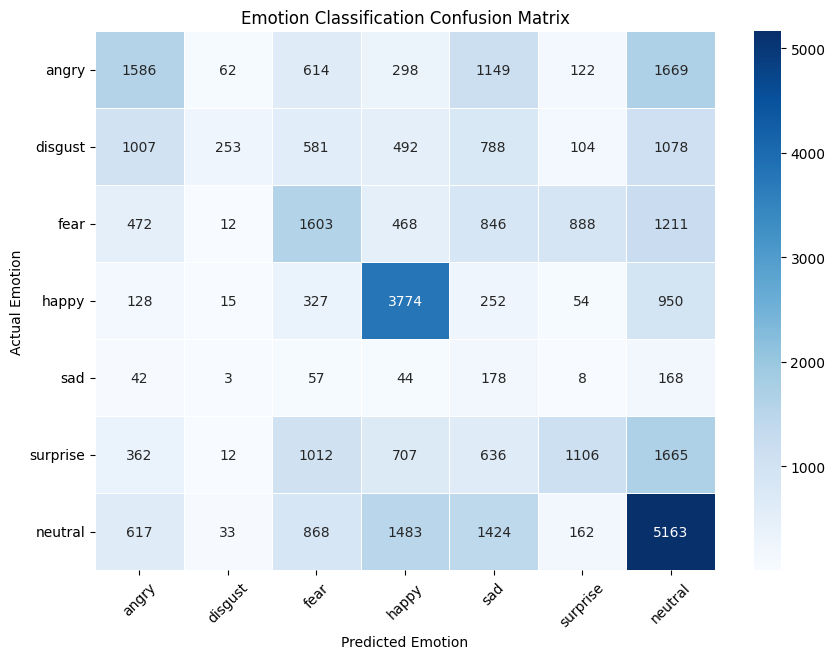

Processing completed for dataset: ./unfiltered1
You can now update DATASET_FOLDER to the next dataset and rerun the script.


In [7]:
# Run the script
if __name__ == "__main__":
    initialize_filtered_dataset()

    # Process each category separately
    for category in EMOTION_CATEGORIES:
        process_category(category)

    # Generate and display confusion matrix
    generate_confusion_matrix()

    print(f"Processing completed for dataset: {DATASET_FOLDER}")
    print("You can now update DATASET_FOLDER to the next dataset and rerun the script.")